In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
plt.style.use('seaborn')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# подсчет метрик и отрисовка модели

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values, R2=False, RMSE=False, MSE=False):
    res=[]
    if R2:
        R2 = f'Train_R2 \t {str(round(r2(train_true_values, train_pred_values), 3))}\nTest_R2 \t {str(round(r2(test_true_values, test_pred_values), 3))}'
        res.append(R2)
    if RMSE:
        RMSE = f'Train_RMSE \t {str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3))}\nTest_RMSE \t {str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3))}'
        res.append(RMSE)
    if MSE:
        MSE = f'Train_MSE \t {str(round(mse(train_true_values, train_pred_values), 3))}\nTest_MSE \t {str(round(mse(test_true_values, test_pred_values), 3))}'
        res.append(MSE)
        
    for i in res:
        print(i, sep='\n')
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values, color='#008080')
    plt.xlabel('Predicted values')
    plt.ylabel('True vslues')
    plt.title(f'TRAIN sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values, color='#008080')
    plt.xlabel('Predicted values')
    plt.ylabel('True vslues')
    plt.title('TEST sample prediction')
    plt.subplots_adjust(wspace=0.3)
    
    plt.show()

In [4]:
# функция снижения использования памяти

def reduce_mem_usage(df):
    """ перебираем все столбцы датафрейма и меняем их тип для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
#                 if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {(100 * (start_mem - end_mem) / start_mem):.2f} %')

## Описание признаков наших

## Data fields

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

# 1) <u>***Загрузка данных***</u>

## загружаем, смотрим, знакомимся

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [6]:
# сжимаем размерность, допуская все значения, кроме np.float32, так как 'numpy.float32' object has no attribute 'is_integer'
# а 'is_integer' нам ещё понадобится

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
reduce_mem_usage(train_df)
reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.79 MB
Decreased by 48.10 %
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.35 MB
Decreased by 51.92 %


In [7]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [8]:
# на первые строчки смотрим

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [9]:
# смотрим и на последние

train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [10]:
# размерчики

train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [11]:
# переменные, их тип, пропуски

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float64 
 3   Square         10000 non-null  float64 
 4   LifeSquare     7887 non-null   float64 
 5   KitchenSquare  10000 non-null  float64 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float64 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float64 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float64 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [12]:
# характеристики

train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


# <u>***2) Визуализация данных, из очистка + feature engineering***</u>

## смотрим графики, вникаем в увиденное

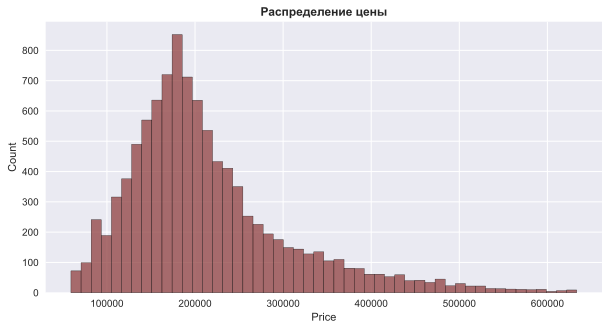

In [13]:
# познакомимся с ценой

plt.figure(figsize = (10, 5))

sns.histplot(train_df.Price, bins=50, color='#8f3f3f')
y = np.linspace(0, 0.000005, 10)
plt.title('Распределение цены', fontweight='bold')
plt.show()

"Хвостик" у цены вполне объясним, так как дорогих квартир ожидаемо меньше

In [14]:
train_df.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

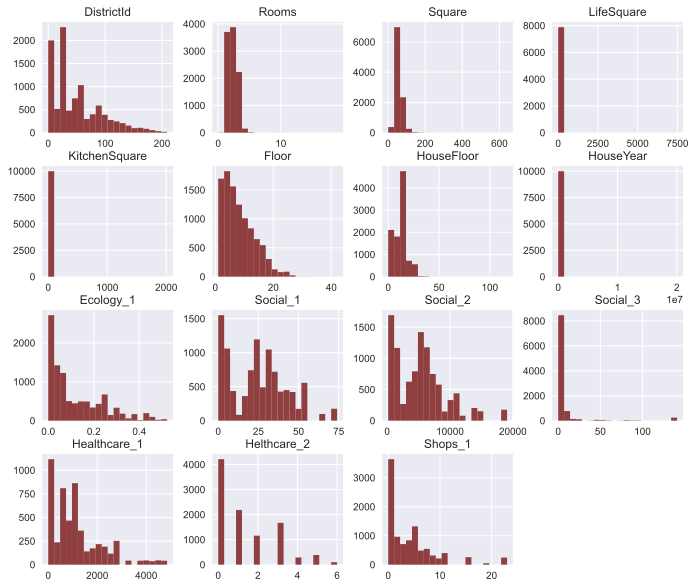

In [15]:
# посмотрим на маленькие гистограммки. Так-то можно строить каждую в отдельности (что было бы видно), 
# но для итоговой работы лучше так, компактней

train_df_features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                     'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
                     'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
train_df[train_df_features].hist(figsize=(11.5,10), bins=20, color='#8f3f3f');

### Rooms - комнатушки

In [16]:
# было:
train_df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
# количество комнат > 11 заменяем средним, а == 0 - первым этажом
# количество комнат = 10 делаем = 1, так как это наверняка опечатка
# 6 комнат станет 5 комнат (так как она такая одна, а 5-тикомнатный вообще-то 18 штук)
# меняем тип данных, убирая тем самым возможные дроби

param = train_df.Rooms.value_counts().index
for i in param:
    if i > 11 or i == 0:
        train_df.loc[train_df.Rooms > 11, 'Rooms'] = round(train_df.Rooms.mean())
        train_df.loc[train_df.Rooms == 0, 'Rooms'] = 1
    elif i == 10:
        train_df.loc[train_df.Rooms == 10, 'Rooms'] = 1
    else:      
        train_df.loc[train_df.Rooms == 6, 'Rooms'] = 5
train_df.Rooms = train_df.Rooms.astype(int)

In [18]:
# стало:

train_df.Rooms.value_counts()

2    3881
1    3715
3    2235
4     150
5      19
Name: Rooms, dtype: int64

### предобработка площадей (пока просто удаление выбросов)

сначала изучаем по всякому

In [19]:
train_df.Square.value_counts().sort_values().head(5), train_df.Square.value_counts().sort_values(ascending=True).tail(5)

(115.027311    1
 49.396000     1
 78.342215     1
 40.409907     1
 64.285067     1
 Name: Square, dtype: int64,
 84.486078    1
 43.303458    1
 49.090728    1
 39.630082    1
 35.815476    1
 Name: Square, dtype: int64)

In [20]:
train_df.LifeSquare.value_counts().sort_values(ascending=False).unique

<bound method Series.unique of 23.169223    1
76.746654    1
47.103833    1
21.772930    1
32.893256    1
            ..
37.038420    1
16.555363    1
22.326870    1
24.734367    1
22.301367    1
Name: LifeSquare, Length: 7887, dtype: int64>

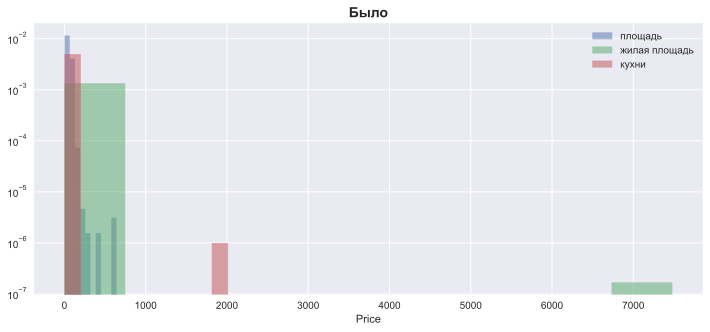

In [21]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Square, density=True, alpha=0.5, label='площадь')
plt.hist(x=train_df.LifeSquare, density=True, alpha=0.5, label='жилая площадь')
plt.hist(x=train_df.KitchenSquare, density=True, alpha=0.5, label='кухни')
plt.yscale(value='log')

plt.xlabel('Price')
plt.legend()
plt.title('Было', fontweight='bold', fontsize=14)
plt.show()

In [22]:
# предварительно по площадям уберём очевидные хвосты

train_df.loc[train_df.Square < 10, 'Square'] = train_df.Square.median()
train_df.loc[train_df.Square > 250, 'Square'] = train_df.Square.median()

# то же и у жилой площади. Наны заполним потом, а пока грохнем крайности

train_df.loc[train_df.LifeSquare <= 5, 'LifeSquare'] = train_df.LifeSquare.median()
train_df.loc[train_df.LifeSquare > 200, 'LifeSquare'] = train_df.LifeSquare.median()

# и кухню сразу. Попробуем среднее + 3 (так как много нулей и единиц снижают общее значение среднего)

train_df.loc[train_df.KitchenSquare <= 3, 'KitchenSquare'] = round(train_df.KitchenSquare.mean() + 3)
train_df.loc[train_df.KitchenSquare > 200, 'KitchenSquare'] = round(train_df.KitchenSquare.mean() + 3)

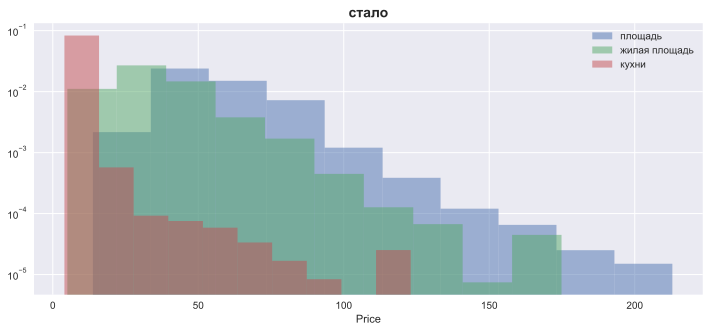

In [23]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Square, density=True, alpha=0.5, label='площадь')
plt.hist(x=train_df.LifeSquare, density=True, alpha=0.5, label='жилая площадь')
plt.hist(x=train_df.KitchenSquare, density=True, alpha=0.5, label='кухни')
plt.yscale(value='log')

plt.xlabel('Price')
plt.legend()
plt.title('стало', fontweight='bold', fontsize=14)
plt.show()

### Этажи квартир и кличество этажей в домах

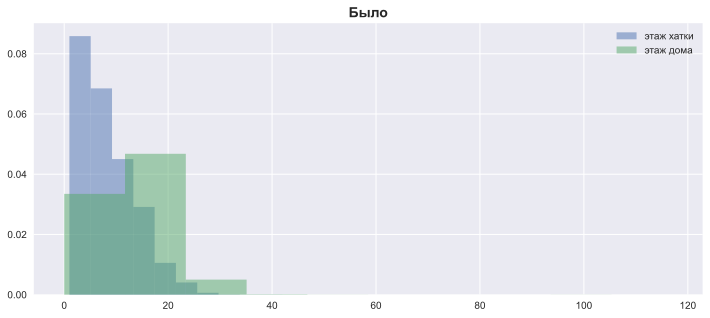

In [24]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Floor, density=True, alpha=0.5, label='этаж хатки')
plt.hist(x=train_df.HouseFloor, density=True, alpha=0.5, label='этаж дома')

plt.legend()
plt.title('Было', fontweight='bold', fontsize=14)
plt.show()

In [25]:
# убираем возможные нули и этажи выше 50-гото и у домов и у квартир

train_df.loc[train_df.HouseFloor > 50, 'HouseFloor'] = round(train_df.HouseFloor.mean())
train_df.loc[train_df.HouseFloor == 0, 'HouseFloor'] = round(train_df.HouseFloor.mean())

train_df.loc[train_df.Floor > 50, 'Floor'] = round(train_df.Floor.mean())
train_df.loc[train_df.Floor == 0, 'Floor'] = round(train_df.Floor.mean())

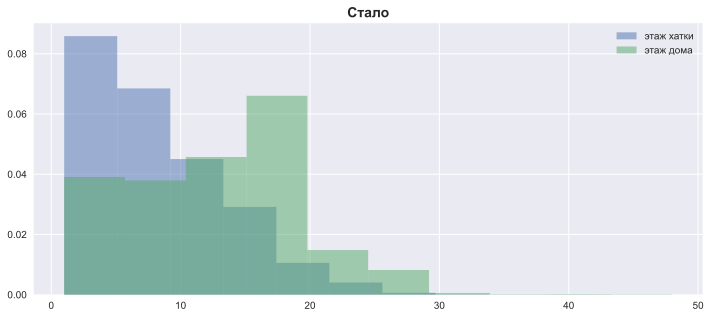

In [26]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Floor, density=True, alpha=0.5, label='этаж хатки')
plt.hist(x=train_df.HouseFloor, density=True, alpha=0.5, label='этаж дома')

plt.legend()
plt.title('Стало', fontweight='bold', fontsize=14)
plt.show()

In [27]:
# у нас тут остаются Карлсоны, которые решили жить выше этажа своего дома. Ну и пусть там остаются, может им так нравится
# а то при каждом попытке переселить их в этажность дома понижается качество модели

### Год постройки дома

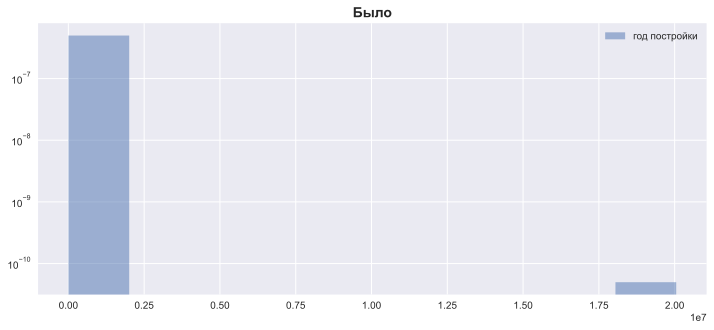

In [28]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.HouseYear, density=True, alpha=0.5, label='год постройки')
plt.yscale(value='log')

plt.legend()
plt.title('Было', fontweight='bold', fontsize=14)
plt.show()

In [29]:
# заменим выбросы один медианой, а второй 2008-м годом (это среднее между 2005 и 2011, т.к. сейчас записано 20052011)

# вот это - разовая операция и только для трейна
train_df.loc[train_df.HouseYear == 20052011, 'HouseYear'] = 2008

# а это для всех
train_df.loc[train_df.HouseYear > 2020, 'HouseYear'] = train_df.HouseYear.median()
train_df.loc[train_df.HouseYear < 1910, 'HouseYear'] = train_df.HouseYear.median()

In [30]:
# проверем наши причёсанные года

print(train_df.HouseYear.min(), train_df.HouseYear.max())

1910 2020


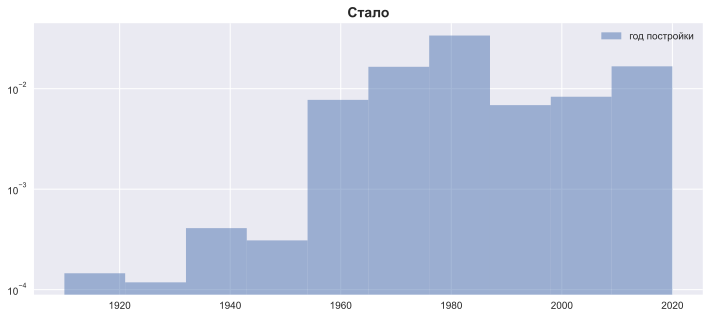

In [31]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.HouseYear, density=True, alpha=0.5, label='год постройки')
plt.yscale(value='log')

plt.legend()
plt.title('Стало', fontweight='bold', fontsize=14)
plt.show()

### Healthcare_1 - с забой о здоровье

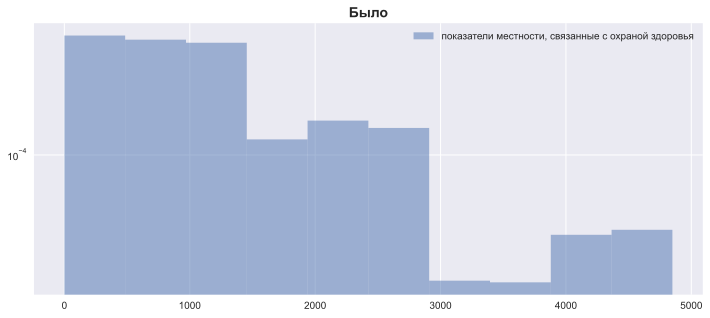

In [32]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Healthcare_1, density=True, alpha=0.5, label='показатели местности, связанные с охраной здоровья')
plt.yscale(value='log')

plt.legend()
plt.title('Было', fontweight='bold', fontsize=14)
plt.show()

In [33]:
# Healthcare_1 есть один, что = 0

train_df.loc[train_df.Healthcare_1 == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8420,9944,23,3,78.062848,NaN,9.0,14,17.0,2017,0.014334,B,B,2,528,0,0.0,0,0,B,431238.467011


In [34]:
# мы зменим его медианой

train_df.loc[train_df.Healthcare_1 == 0, 'Healthcare_1'] = train_df.Healthcare_1.median()

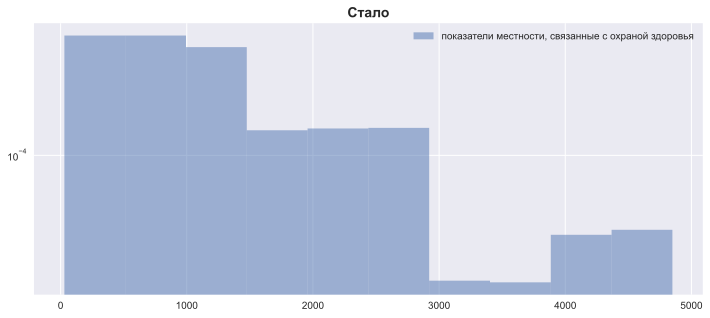

In [35]:
plt.figure(figsize=(12,5))
plt.hist(x=train_df.Healthcare_1, density=True, alpha=0.5, label='показатели местности, связанные с охраной здоровья')
plt.yscale(value='log')

plt.legend()
plt.title('Стало', fontweight='bold', fontsize=14)
plt.show()

## заполняем пропуски

In [36]:
# напомним себе, как дело обстоит:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int32   
 3   Square         10000 non-null  float64 
 4   LifeSquare     7887 non-null   float64 
 5   KitchenSquare  10000 non-null  float64 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float64 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float64 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float64 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [37]:
# вот они, пропуски наши любимые
train_df.isna().sum() 

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Healthcare_1

In [38]:
# заполним Healthcare_1 средним

mean_Healthcare_1 = train_df.Healthcare_1.mean()
train_df.Healthcare_1 = train_df.Healthcare_1.fillna(mean_Healthcare_1)

### LifeSquare

In [39]:
# и с LifeSquare поступим так же. 

mean_LifeSquare = train_df.LifeSquare.mean()
train_df.LifeSquare = train_df.LifeSquare.fillna(mean_LifeSquare)

Пояснительная бригада: я пробовал заполнять Healthcare_1 и LifeSquare отдельным прогнозом по этим столбцам, написал даже красивую умную функцию под это дело, но, увы, чем точнее результат, тем хуже итоговый прогноз) чего не скажешь про заполнение средним. Поэтому оставляю так

## работаем с переменными

In [40]:
# удаляем категориальные  переменные

train_df = train_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

In [41]:
# айдишники сделаем типом object

train_df.Id = train_df.Id.astype(str)

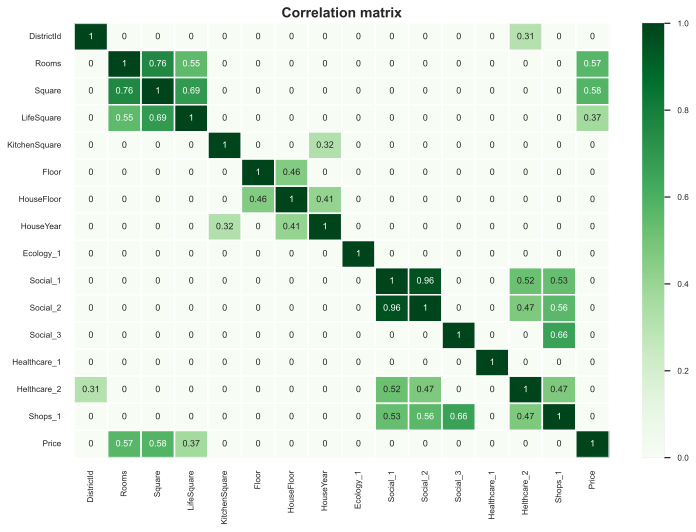

In [42]:
# и построим корреляционную матрицу, чтоб понять, что имеем

plt.figure(figsize = (12,8))
sns.set(font_scale=0.75)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=1.5, cmap='Greens')

plt.title('Correlation matrix', fontweight='bold', fontsize=14)
plt.show()

In [43]:
# добавляем вот что и почему: так как модель у нас шибко ошибается на дорогих домах, мы создадим признак
# - Size_District, который будет основан на количестве домов в каждом районе

Size_District = train_df.DistrictId.value_counts().reset_index().rename(
    columns={'index':'DistrictId', 'DistrictId':'Size_District'})
train_df = train_df.merge(Size_District, on='DistrictId', how='left')

In [44]:
# и логичный ещё один признак, в который поместим 0 там, где домов меньше 100, и 1 там, где домов, соотвестственно, больше: 

train_df['Large_Area'], train_df.loc[train_df.Size_District > 100, 'Large_Area'] = 0, 1

In [45]:
# размер был

train_df.shape

(10000, 19)

In [46]:
# массово генерируем признаки медианы по самым коррелирующим с таргетом переменным, это у нас Rooms, Square и LifeSquare

all_elements = list(train_df.keys())
if 'Price' in all_elements:
    all_elements.remove('Price')

top_features = ['Rooms', 'Square', 'LifeSquare']
stop_list = ['Id', 'Price']
for x in top_features:
    stop_list.append(x)
    for i in all_elements:
        if i in stop_list:
            continue
        name = f'{x}_{i}'
        name = train_df.groupby(x).agg({i: 'median'}).rename(
            columns={i: name})
        train_df = train_df.merge(name, how='left', on=x)

In [47]:
# размер стал

train_df.shape

(10000, 64)

# <u>***3) Разбиение данных на train и test + построение ML моделей***</u>

## RandomForestRegressor

Train_R2 	 0.963
Test_R2 	 0.74


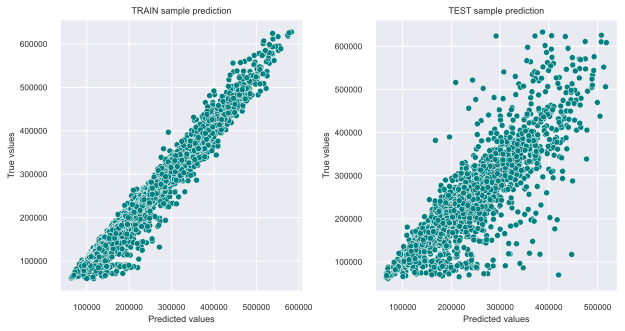

In [48]:
target = 'Price'
y = train_df[target]
X = train_df.drop(target, axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

forest = RandomForestRegressor(random_state=42)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_valid)

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred, R2=True)

# <u>***4) Подготовка данных в DataPipeline***</u>

In [49]:
class DataPipeline:
    
    def __init__(self):
        self.mean = None
        self.median = None

    def fit(self, df):
        """Сохранение статистик"""
        # Расчет медиан и среднего
        self.Square_median = df.Square.median()
        self.LifeSquare_median =  df.LifeSquare.median()
        self.HouseYear_median = df.HouseYear.median()
        self.Healthcare_1_median = df.Healthcare_1.median()
        self.Rooms_mean = round(df.Rooms.mean())
        self.KitchenSquare_mean = round(df.KitchenSquare.mean() + 3)
        self.HouseFloor_mean = round(df.HouseFloor.mean())
        self.Floor_mean = round(df.Floor.mean())
        self.Healthcare_1_mean = df.Healthcare_1.mean()
        self.LifeSquare_mean = df.LifeSquare.mean()
        
    def transform(self, df):        
        # комнаты
        param = df.Rooms.value_counts().index
        for i in param:
            if i > 11 or i == 0:
                df.loc[df.Rooms > 11, 'Rooms'] = self.Rooms_mean
                df.loc[df.Rooms == 0, 'Rooms'] = 1
            elif i == 10:
                df.loc[df.Rooms == 10, 'Rooms'] = 1
            else:      
                df.loc[df.Rooms == 6, 'Rooms'] = 5
        df.Rooms = df.Rooms.astype(int)
        # площадь 
        df.loc[df.Square < 10, 'Square'] = self.Square_median
        df.loc[df.Square > 250, 'Square'] = self.Square_median
        df.loc[df.LifeSquare <= 5, 'LifeSquare'] = self.LifeSquare_median
        df.loc[df.LifeSquare > 200, 'LifeSquare'] = self.LifeSquare_median
        df.loc[df.KitchenSquare <= 3, 'KitchenSquare'] = self.KitchenSquare_mean
        df.loc[df.KitchenSquare > 200, 'KitchenSquare'] = self.KitchenSquare_mean
        # этажи
        df.loc[df.HouseFloor > 50, 'HouseFloor'] = self.HouseFloor_mean
        df.loc[df.HouseFloor == 0, 'HouseFloor'] = self.HouseFloor_mean
        df.loc[df.Floor > 50, 'Floor'] = self.Floor_mean
        df.loc[df.Floor == 0, 'Floor'] = self.Floor_mean
        # годы
        df.loc[df.HouseYear == 20052011, 'HouseYear'] = 2008
        df.loc[df.HouseYear > 2020, 'HouseYear'] = self.HouseYear_median
        df.loc[df.HouseYear < 1910, 'HouseYear'] = self.HouseYear_median
        # здоровье богатырское
        df.loc[df.Healthcare_1 == 0, 'Healthcare_1'] = self.Healthcare_1_median
        # трансформация данных
        # Пропуски
        # Healthcare_1
        df.Healthcare_1 = df.Healthcare_1.fillna(self.Healthcare_1_mean)
        # LifeSquare
        df.LifeSquare = df.LifeSquare.fillna(self.LifeSquare_mean)
        # удаляем категориальные  переменные
        df = df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
        # айдишники сделаем типом object
        df.Id = df.Id.astype(str)
        # генерация признаков
        # Size_District
        Size_District = df.DistrictId.value_counts().reset_index().rename(
            columns={'index':'DistrictId', 'DistrictId':'Size_District'})
        df = df.merge(Size_District, on='DistrictId', how='left')
        # Large_Area
        df['Large_Area'], df.loc[df.Size_District > 100, 'Large_Area'] = 0, 1
        # по коррелирующим признакам
        all_elements = list(df.keys())
        if 'Price' in all_elements:
            all_elements.remove('Price')
        top_features = ['Rooms', 'Square', 'LifeSquare']
        stop_list = ['Id', 'Price']
        for x in top_features:
            stop_list.append(x)
            for i in all_elements:
                if i in stop_list:
                    continue
                name = f'{x}_{i}'
                name = df.groupby(x).agg({i: 'median'}).rename(
                    columns={i: name})
                df = df.merge(name, how='left', on=x)
        return df

# <u>***5) Предсказание только на X_train***</u>

In [50]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
reduce_mem_usage(train_df)
reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.79 MB
Decreased by 48.10 %
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.35 MB
Decreased by 51.92 %


In [51]:
target = 'Price'
y = train_df[target]
X = train_df.drop(target, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, test_df.shape

((7000, 19), (3000, 19), (5000, 19))

In [52]:
preprocessor = DataPipeline()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train.copy())
X_valid = preprocessor.transform(X_valid.copy())
test_df = preprocessor.transform(test_df)

Train_R2 	 0.963
Test_R2 	 0.634


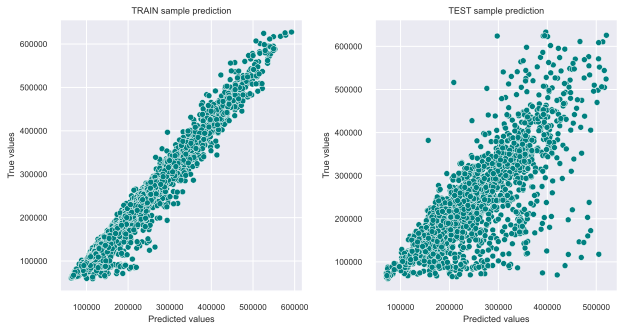

In [53]:
forest = RandomForestRegressor(random_state=42)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_valid)

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred, R2=True)

ну в 0.6 попали, уже хорошо)

# <u>***6) Итоговое предсказание***</u>

In [54]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
reduce_mem_usage(train)
reduce_mem_usage(test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.79 MB
Decreased by 48.10 %
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.35 MB
Decreased by 51.92 %


In [55]:
preprocessor = DataPipeline()
preprocessor.fit(train)
train = preprocessor.transform(train.copy())
test = preprocessor.transform(test.copy())

In [56]:
target = 'Price'
y = train[target]
X = train.drop(target, axis=1)

In [57]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X, y)

RandomForestRegressor(random_state=42)

In [58]:
test['Price'], dz_file = forest.predict(test), pd.DataFrame(forest.predict(test), columns=['Price'])

In [59]:
test[['Id', 'Price']].to_csv('MSolin_predictions_index.csv', index=None)

In [60]:
pd.read_csv('MSolin_predictions_index.csv').head()

,Id,Price
0,4567,152698.108615
1,5925,159323.520419
2,960,151973.381474
3,3848,113668.784789
4,746,222467.668087


In [61]:
f_pred = pd.read_csv(TEST_DATASET_PATH)
f_pred['Price'] = dz_file
dz_file.to_csv('MSolin_predictions.csv', index=False)

In [64]:
pd.read_csv('MSolin_predictions.csv').head()

,Price
0,152698.108615
1,159323.520419
2,151973.381474
3,113668.784789
4,222467.668087


In [62]:
# финальная проверка размера файла
MSolin_predictions = pd.read_csv('MSolin_predictions.csv')
MSolin_predictions.shape

(5000, 1)